# Albedo calculation from all satellites

### Importation

In [2]:
import ee
# Initialiser Earth Engine
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()
    
import geemap
import sentinel2
import landsat
import pandas as pd
from matplotlib import pyplot as plt
import useful_function as uf
import zones_teledec as zt

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


### Computation and visulization of albedo

In [3]:
zone = zt.Area.MID_AREA.value

start_date = '2020-01-01'
end_date = '2021-01-01'

dataset_sentinel = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterDate(start_date, end_date) \
    .filterBounds(zone) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .map(sentinel2.mask_s2_clouds)

dataset_landsat_8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterDate(start_date, end_date) \
    .filterBounds(zone) \
    .filter(ee.Filter.lt('CLOUD_COVER', 20)) \
    .map(landsat.mask_landsat_clouds) 

dataset_landsat_9 = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filterDate(start_date, end_date) \
    .filterBounds(zone) \
    .filter(ee.Filter.lt('CLOUD_COVER', 20)) \
    .map(landsat.mask_landsat_clouds) 


albedo_s2 = dataset_sentinel.map(sentinel2.compute_albedo)
albedo_landsat_8 = dataset_landsat_8.map(landsat.compute_albedo_l8_l9)
albedo_landsat_9 = dataset_landsat_9.map(landsat.compute_albedo_l8_l9)

global_albedo = albedo_s2.merge(albedo_landsat_8).merge(albedo_landsat_9)

sentinelVis = {
    'min': 0.0,
    'max': 400.0,
    'bands': ['TCI_R', 'TCI_G', 'TCI_B']
}

imageVisParamAlbedo = {
    'opacity': 1,
    'bands': ['albedo'],
    'min': 0.003000000026077032,
    'max': 0.2693333327770233,
    'palette': ['000000', '1200ff', '0dff00', 'ff0000']
}

# create a map
Map = geemap.Map()

Map.addLayer(dataset_sentinel.mean().clip(zone), sentinelVis, 'Sentinel-2 vis', False)

Map.addLayer(global_albedo.mean().clip(zone) , imageVisParamAlbedo, 'global_albedo', True)
Map.addLayer(albedo_s2.mean().clip(zone), imageVisParamAlbedo, 'albedo_s2', True)
Map.addLayer(albedo_landsat_8.mean().clip(zone), imageVisParamAlbedo, 'albedo_landsat_8', False)
Map.addLayer(albedo_landsat_9.mean().clip(zone), imageVisParamAlbedo, 'albedo_landsat_9', False)

Map.centerObject(zone)
Map.addLayerControl()

Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

### Coefficients computation 

We use the file format returned by SMARTS (.ext.txt) and we transform it into a CSV file

SMARTS : https://www.nrel.gov/grid/solar-resource/smarts.html

In [1]:
# on ouvre un fichier txt dans un dataframe puis on l'enregistre au format csv
df = pd.read_csv("data/desert_summer.ext.txt", sep=" ", header=None)

# on enregistre le dataframe au format csv avec pour titre la premiere ligne du fichier txt
df.columns = df.iloc[0]
df = df[1:]
df.to_csv("data/Desert_Summer_300to4000.csv", sep=",", index=False)

In [4]:
irradiance_file_summer_france = "data/MLS_300to4000_fr.csv"

bands_s2 = [[300, 533], [533, 614], [614, 730], [730, 1226], [1226, 1880], [1880, 3000]]
print('coeff S2 summer : ' + str(uf.coefficients_calculation(bands_s2, irradiance_file_summer_france, 300, 3000)))
print('\n')

bands_l7 = [[300, 520], [520, 615], [615, 725], [725, 1225], [1225, 1915], [1915, 4000]]
print('coeff l7 summer : ' + str(uf.coefficients_calculation(bands_l7, irradiance_file_summer_france, 300, 4000)))
print('\n')

bands_l8_l9 = [[300, 451], [451, 522], [522, 613], [613, 762], [762, 1222], [1222, 1879], [1879, 4000]]
print('coeff l8-l9 summer : ' + str(uf.coefficients_calculation(bands_l8_l9, irradiance_file_summer_france, 300, 4000)))
print('\n')

bands_prisma = []
df_prisma = pd.read_csv("data/prisma_bands.csv")
for i in range(0, len(df_prisma)):
    borne_min = df_prisma.loc[i, 'borne_min']
    borne_max = df_prisma.loc[i, 'borne_max']
    bands_prisma.append([borne_min, borne_max])

coeff_prisma = uf.coefficients_calculation(bands_prisma, irradiance_file_summer_france, 403, 2501)

# We add a new column to the dataframe for coefficients
df_prisma['coeff'] = coeff_prisma

# We save the dataframe with the coefficients
# df_prisma.to_csv("data/prisma_bands_coeff_summer.csv", sep=",", index=False)

print('coeff PRISMA summer : ' + str(coeff_prisma))

coeff S2 summer : [np.float64(0.22605081620173895), np.float64(0.12513826634639683), np.float64(0.15804816263810165), np.float64(0.3408016673127353), np.float64(0.11601772668271282), np.float64(0.03394336081831444)]


coeff l7 summer : [np.float64(0.204043872129643), np.float64(0.14606731516826357), np.float64(0.15029208676230038), np.float64(0.3429313791748935), np.float64(0.11565149702842839), np.float64(0.041013849736471125)]


coeff l8-l9 summer : [np.float64(0.09662203364296014), np.float64(0.11052506872088694), np.float64(0.13998546405536413), np.float64(0.1963030623992841), np.float64(0.29851100194879937), np.float64(0.11703944343149952), np.float64(0.04101392003087783)]


coeff PRISMA summer : [np.float64(0.008678760076876894), np.float64(0.010767574857531239), np.float64(0.009733930844644214), np.float64(0.00794942882448422), np.float64(0.009423801662914793), np.float64(0.012017205976487363), np.float64(0.011255674536432527), np.float64(0.011500923637993493), np.float64(0.0130

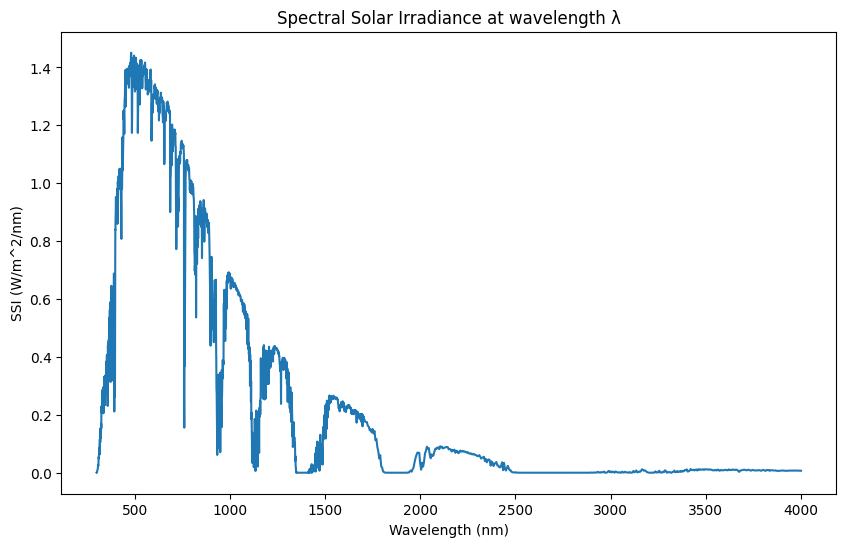

In [5]:
# Check if spectral solar irradiance is good 

df = pd.read_csv('data/MLS_300to4000_fr.csv')

# on ne garde que les colonnes qui nous intéressent
df = df[['Wvlgth', 'Direct_normal_irradiance']]

# on renomme les colonnes
df.columns = ['wavelength', 'SSI']

# on affiche graphiquement les données
plt.figure(figsize=(10, 6))
plt.plot(df['wavelength'], df['SSI'], label='Irradiance at wavelength λ')
plt.xlabel('Wavelength (nm)')
plt.ylabel('SSI (W/m^2/nm)')
plt.title('Spectral Solar Irradiance at wavelength λ')
plt.show()